<a href="https://www.kaggle.com/code/dmmehedihasanabid/resnet-50?scriptVersionId=289713978" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Library Functions

In [1]:
# =========================
# Block 1: Imports
# =========================
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights

from sklearn.metrics import confusion_matrix, classification_report


# Block 2 — Set Seed + Device + Find Class Root Folder

In [2]:
# ==========================================
# Block 2: Reproducibility + Device + Root
# ==========================================
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

DATASET_DIR = "/kaggle/input/potato-dataset"

# Try to detect ImageFolder root: folder that directly contains class subfolders
def find_imagefolder_root(base_dir):
    image_exts = (".jpg", ".jpeg", ".png", ".bmp", ".webp")
    candidates = [base_dir] + [
        os.path.join(base_dir, d) for d in os.listdir(base_dir)
        if os.path.isdir(os.path.join(base_dir, d))
    ]

    def count_class_like_subfolders(path):
        if not os.path.isdir(path):
            return 0
        subdirs = [os.path.join(path, d) for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
        score = 0
        for sd in subdirs:
            # if any image exists inside this subdir tree, treat it as class-like
            found = False
            for r, _, files in os.walk(sd):
                if any(f.lower().endswith(image_exts) for f in files):
                    found = True
                    break
            if found:
                score += 1
        return score

    best_path, best_score = None, -1
    for cand in candidates:
        score = count_class_like_subfolders(cand)
        if score > best_score:
            best_score = score
            best_path = cand

    return best_path, best_score

CLASS_ROOT, score = find_imagefolder_root(DATASET_DIR)
print("Detected CLASS_ROOT:", CLASS_ROOT)
print("Score (class-like subfolders):", score)
print("Subfolders:", [d for d in os.listdir(CLASS_ROOT) if os.path.isdir(os.path.join(CLASS_ROOT, d))])


Device: cuda
Detected CLASS_ROOT: /kaggle/input/potato-dataset
Score (class-like subfolders): 3
Subfolders: ['Potato___healthy', 'Potato___Late_blight', 'Potato___Early_blight']


# Block 3 — Transforms (Train Augmentation + Val/Test Clean)

In [3]:
# ==========================================
# Block 3: Transforms
# ==========================================
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=ResNet50_Weights.DEFAULT.transforms().mean,
                         std=ResNet50_Weights.DEFAULT.transforms().std),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=ResNet50_Weights.DEFAULT.transforms().mean,
                         std=ResNet50_Weights.DEFAULT.transforms().std),
])


# Block 4 — Load Dataset (ImageFolder) + 80/10/10 Split

In [4]:
# ==================================================
# Block 4: Dataset Loading + 80/10/10 Split
# ==================================================
full_dataset_for_split = datasets.ImageFolder(root=CLASS_ROOT)  # no transform yet; just to split
class_names = full_dataset_for_split.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total images:", len(full_dataset_for_split))
print("Num classes:", num_classes)

# Calculate split sizes
n_total = len(full_dataset_for_split)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)
n_test = n_total - n_train - n_val

print("Split sizes -> Train:", n_train, "Val:", n_val, "Test:", n_test)

# Deterministic split
generator = torch.Generator().manual_seed(SEED)
train_indices, val_indices, test_indices = random_split(
    range(n_total),
    lengths=[n_train, n_val, n_test],
    generator=generator
)

# Now create datasets with transforms applied
train_dataset = datasets.ImageFolder(root=CLASS_ROOT, transform=train_transform)
val_dataset   = datasets.ImageFolder(root=CLASS_ROOT, transform=eval_transform)
test_dataset  = datasets.ImageFolder(root=CLASS_ROOT, transform=eval_transform)

# Apply the split subsets
train_dataset = torch.utils.data.Subset(train_dataset, train_indices.indices)
val_dataset   = torch.utils.data.Subset(val_dataset, val_indices.indices)
test_dataset  = torch.utils.data.Subset(test_dataset, test_indices.indices)


Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
Total images: 2152
Num classes: 3
Split sizes -> Train: 1721 Val: 215 Test: 216


# Block 5 — DataLoad

In [5]:
# ==========================================
# Block 5: DataLoaders
# ==========================================
BATCH_SIZE = 32
NUM_WORKERS = 2  # Kaggle usually ok with 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("Loaders ready.")


Loaders ready.


# Block 6 — Visualize a Few Training Images (Sanity Check)

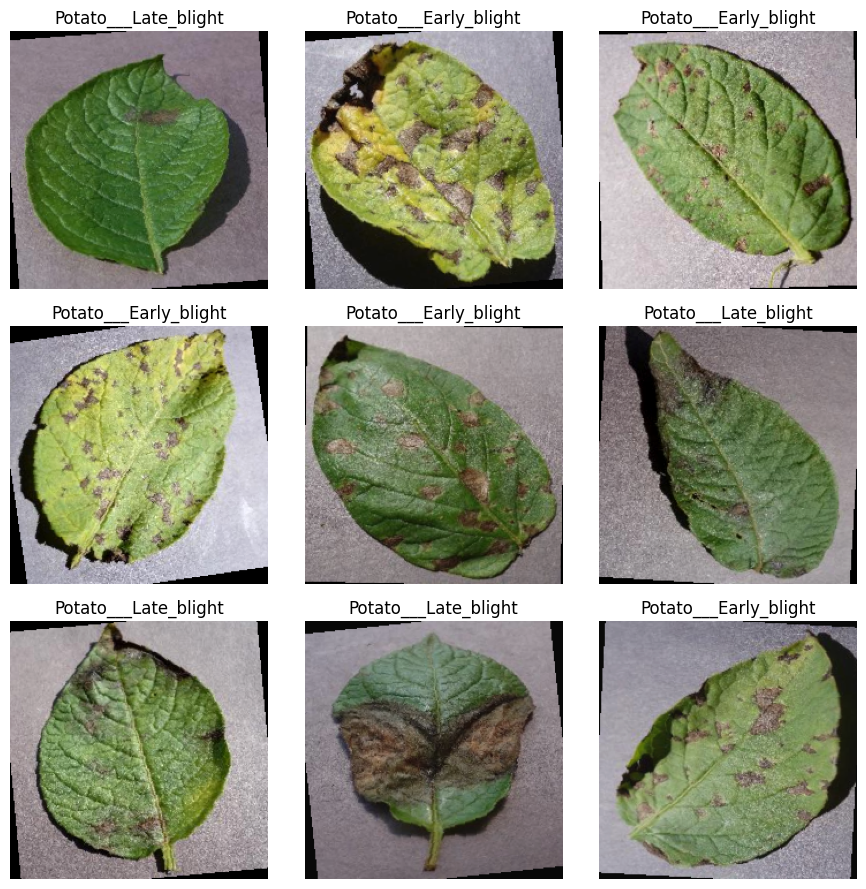

In [6]:
# ==========================================
# Block 6: Show Sample Images
# ==========================================
def denormalize(img_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img_tensor * std + mean

mean = ResNet50_Weights.DEFAULT.transforms().mean
std  = ResNet50_Weights.DEFAULT.transforms().std

images, labels = next(iter(train_loader))

plt.figure(figsize=(9, 9))
for i in range(min(9, images.size(0))):
    ax = plt.subplot(3, 3, i+1)
    img = denormalize(images[i].cpu(), mean, std).clamp(0, 1)
    plt.imshow(img.permute(1, 2, 0))
    plt.title(class_names[int(labels[i])])
    plt.axis("off")
plt.tight_layout()
plt.show()


# Block 7 — Build ResNet50 Model (Backbone = 50)

In [7]:
# ==========================================
# Block 7: ResNet50 Model (Backbone=50)
# ==========================================
model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

# Replace final layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

print(model)


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Block 8 — Loss Function + SGD Optimizer (lr=0.001)

In [8]:
# ==========================================
# Block 8: Loss + Optimizer
# ==========================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# Block 9 — Training + Validation Functions (Complete)

In [9]:
# ==========================================
# Block 9: Train/Eval Functions
# ==========================================
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        running_correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


# Block 10 — Train for up to 10 Epochs + Save Best Model + Early Stopping

In [10]:
# ==========================================
# Block 10: Train (10 epochs) + Best Model Save + Early Stopping
# ==========================================
EPOCHS = 10
PATIENCE = 3  # stop if val acc doesn't improve for 3 epochs

best_val_acc = -1.0
epochs_without_improvement = 0
best_path = "best_resnet50.pth"

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_without_improvement = 0
        torch.save(model.state_dict(), best_path)
        print("Val Acc improved -> Saved best model.")
    else:
        epochs_without_improvement += 1
        print(f"⚠ No improvement for {epochs_without_improvement} epoch(s).")

    # Early stopping
    if epochs_without_improvement >= PATIENCE:
        print("Early stopping triggered.")
        break

print("\nTraining finished.")
print("Best Validation Accuracy:", best_val_acc)
print("Best model saved at:", best_path)


Epoch 01/10 | Train Loss: 0.7730 Acc: 0.7182 | Val Loss: 0.4863 Acc: 0.9163
Val Acc improved -> Saved best model.
Epoch 02/10 | Train Loss: 0.3228 Acc: 0.9053 | Val Loss: 0.2058 Acc: 0.9349
Val Acc improved -> Saved best model.
Epoch 03/10 | Train Loss: 0.1661 Acc: 0.9471 | Val Loss: 0.1209 Acc: 0.9814
Val Acc improved -> Saved best model.
Epoch 04/10 | Train Loss: 0.1044 Acc: 0.9791 | Val Loss: 0.0753 Acc: 0.9860
Val Acc improved -> Saved best model.
Epoch 05/10 | Train Loss: 0.0689 Acc: 0.9849 | Val Loss: 0.0532 Acc: 0.9953
Val Acc improved -> Saved best model.
Epoch 06/10 | Train Loss: 0.0465 Acc: 0.9919 | Val Loss: 0.0401 Acc: 0.9953
⚠ No improvement for 1 epoch(s).
Epoch 07/10 | Train Loss: 0.0406 Acc: 0.9884 | Val Loss: 0.0346 Acc: 0.9907
⚠ No improvement for 2 epoch(s).
Epoch 08/10 | Train Loss: 0.0340 Acc: 0.9919 | Val Loss: 0.0305 Acc: 0.9907
⚠ No improvement for 3 epoch(s).
Early stopping triggered.

Training finished.
Best Validation Accuracy: 0.9953488372093023
Best model s

# Block 11 — Plot Graphs (Loss & Accuracy)

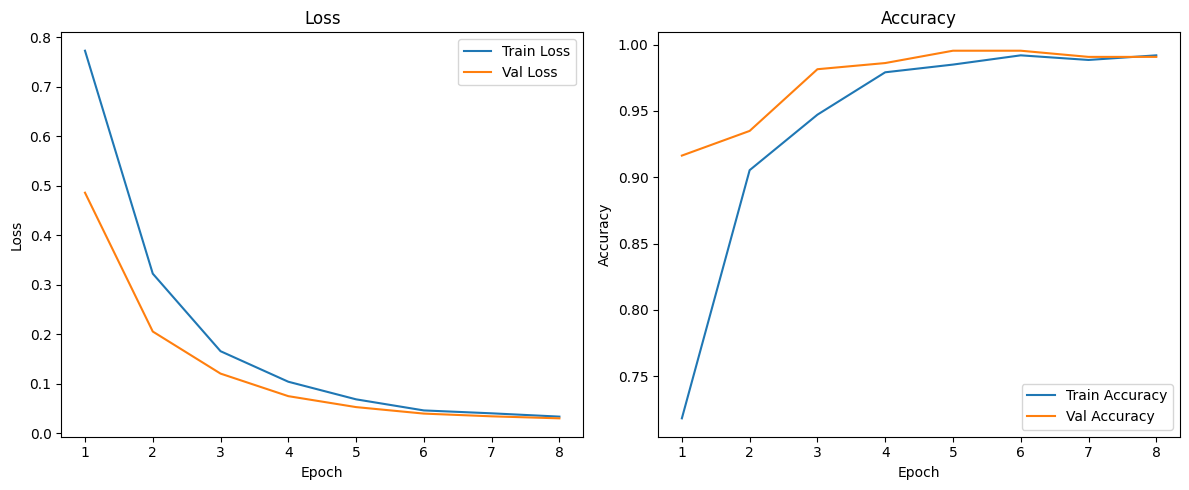

In [11]:
# ==========================================
# Block 11: Plot Training Curves
# ==========================================
epochs_done = len(history["train_loss"])
epochs_range = range(1, epochs_done + 1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss")
plt.plot(epochs_range, history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Train Accuracy")
plt.plot(epochs_range, history["val_acc"], label="Val Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# lock 12 — Test Evaluation (Load Best Model First)

In [12]:
# ==========================================
# Block 12: Evaluate on Test Set (Load Best Model)
# ==========================================
model.load_state_dict(torch.load(best_path, map_location=device))
model = model.to(device)

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Test Loss: 0.0478
Test Accuracy: 1.0000


# Block 13 — Confusion Matrix + Classification Report

Classification Report:

                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00       111
 Potato___Late_blight       1.00      1.00      1.00        93
     Potato___healthy       1.00      1.00      1.00        12

             accuracy                           1.00       216
            macro avg       1.00      1.00      1.00       216
         weighted avg       1.00      1.00      1.00       216



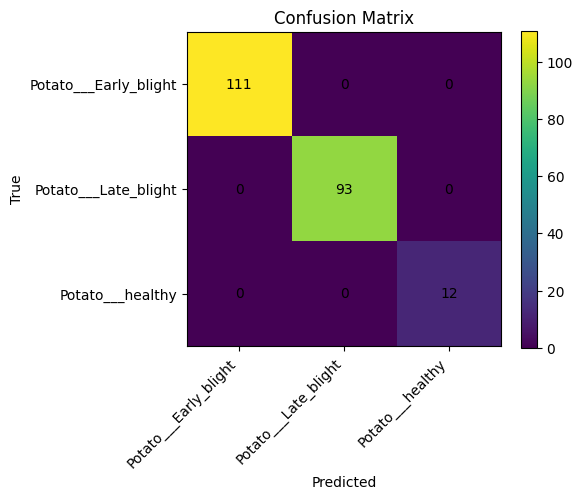

In [13]:
# ==========================================
# Block 13: Confusion Matrix + Classification Report
# ==========================================
@torch.no_grad()
def get_all_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

    return np.array(all_labels), np.array(all_preds)

y_true, y_pred = get_all_predictions(model, test_loader, device)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xticks(range(num_classes), class_names, rotation=45, ha="right")
plt.yticks(range(num_classes), class_names)
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("True")

for i in range(num_classes):
    for j in range(num_classes):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()
